# Final Project: Classifying Covid-19 mortality-level


In this project, we use what we've learned in class to create a classifier that predicts the level of mortality of Covid-19 in US states.

Our analysis contains the following components:

- The data science lifecycle: data selection and cleaning, EDA, feature engineering, and model selection.
- Using `sklearn` to process data and fit decision tree and random forest models.
- Embedding decision tree as a component in a more complex model. Build a regression tree.

**Team members**: *Sophie Lou, Zihan Wen*

In [1]:
#install the packages
!pip install geopandas
!pip install ensemble
!pip install graphviz


In [2]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

## The Data
Attributes of all US Covid-19 cases on April 18 are published by the [CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

Columns of the `state` table in `4.18states.csv` include:
- `Province_State`: Province, state or dependency name.
- `Country_Region`: Country, region or sovereignty name.
- `Last Update`: MM/DD/YYYY HH:mm:ss (24 hour format, in UTC).
- `Lat and Long_`: The latitude and longitute of a state.
- `Confirmed`: Confirmed cases include presumptive positive cases and probable cases.
- `Deaths`: Death totals including confirmed and probable.
- `Recovered`: Recovered cases.
- `Active`: Active cases = total confirmed - total recovered - total deaths.
- `FIPS`: US only. Federal Information Processing Standards code that uniquely identifies counties within the USA.
- `Incident_Rate`: confirmed cases per 100,000 persons.
- `People_Tested`: Total number of people who have been tested.
- `People_Hospitalized`: Total number of people hospitalized.
- `Mortality_Rate`: Number recorded deaths * 100/ Number confirmed cases.
- `UID`: Unique Identifier for each row entry.
- `ISO3`: Officialy assigned country code identifiers.
- `Testing_Rate`: Total number of people tested per 100,000 persons.
- `Hospitalization_Rate`: Total number of people hospitalized * 100/ Number of confirmed cases.

In [4]:
state = pd.read_csv('4.18states.csv')
state.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


Attributes of all information of different counties of US are published by [tiffanymtang](https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md).

Columns of the `info` table in `abridged_couties.csv` include:
- `countyFIPS`: state-county FIPS Code
- `STATEFP`: state FIPS Code
- `COUNTYFP`: county FIPS Code	
- `CountyName`: county name
- `StateName`: state abbreviation
- `State`: state name
- ...
- `PopulationEstimate2018`: estimated total population of county in 2018
- `PopulationEstimate65+2017`: estimated population of 65+ age group in county in 2017
- `#EligibleforMedicare2018`: number of people eligible for Medicare in county in 2018
- `MedicareEnrollment,AgedTot2017`: medicare enrollment (based on age requirement) in the county in 2017
- `Smokers_Percentage`: estimated percentage of adult smokers in county (2017)
- `#FTEHospitalTotal2017`: number of full-time employees at hospitals in 2017
- `#Hospitals`: number of hospitals in the Hospital Compare general information file, for each county	
- `#ICU_beds`: number of ICU beds reported in the most recent cost report for each hospital

In [5]:
info = pd.read_csv('abridged_couties.csv')
info.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


## Part 1: Data Selection and Cleaning
In this part, we limit the data to states only in the US.

### 1a) state dataframe

In [6]:
#Countries that are included in the original state dataset
state['Country_Region'].unique()

array(['US', 'Canada', 'United Kingdom', 'China', 'Netherlands',
       'Australia', 'Denmark', 'France'], dtype=object)

In [7]:
#We only include states within US
US_state = state.loc[state['Country_Region']=='US']
US_state.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


In [8]:
#Countries that are included in the cleaned dataset
US_state['Country_Region'].unique()

array(['US'], dtype=object)

In [9]:
#To double check, we see the states included in the dataset
US_state['Province_State'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Recovered'], dtype=object)

We found Diamond Princess and Grand Princess are included in `state`. There is also an entry called Recovered. Since we are only concerned about American states, we drop those rows. 

In [10]:
#Find the index of these row
array = ['Diamond Princess', 'Grand Princess', 'Recovered']
US_state.loc[US_state['Province_State'].isin(array)]

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
9,Diamond Princess,US,2020-04-18 22:32:47,NaN,NaN,49,0,0.0,49.0,88888.0,NaN,NaN,NaN,0.0,84088888,USA,NaN,NaN
13,Grand Princess,US,2020-04-18 22:32:47,NaN,NaN,103,0,0.0,103.0,99999.0,NaN,NaN,NaN,0.0,84099999,USA,NaN,NaN
116,Recovered,US,NaN,NaN,NaN,0,0,64840.0,-64840.0,NaN,NaN,NaN,NaN,NaN,84070001,USA,NaN,NaN


In [11]:
US_state = US_state.drop([9,13,116]).reset_index(drop=True)
US_state.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


In [12]:
US_state['Province_State'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Now we have the dataset `US_state` with 50 US states, 1 Federal district and 5 US territories. We want to drop some unrelated columns like IDs and clean the column labels.

In [13]:
US_state = US_state.drop(['Last_Update','UID','ISO3','FIPS'], axis=1).rename(columns={'Long_': 'Long'})
US_state.head()

,Province_State,Country_Region,Lat,Long,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,Alabama,US,32.3182,-86.9023,4712,153,NaN,4559.0,100.492717,42538.0,620.0,3.247029,907.206961,13.157895
1,Alaska,US,61.3707,-152.4044,314,9,147.0,305.0,52.530410,9655.0,39.0,2.866242,1615.226458,12.420382
2,American Samoa,US,-14.2710,-170.1320,0,0,NaN,NaN,0.000000,3.0,NaN,NaN,5.391708,NaN
3,Arizona,US,33.7298,-111.4312,4724,180,539.0,4544.0,64.901548,51045.0,566.0,3.810330,701.291175,11.981372
4,Arkansas,US,34.9697,-92.3731,1744,38,703.0,1706.0,67.361213,24141.0,291.0,2.178899,932.435235,16.685780


From the `US_state` dataframe, we see a lot of `NaN` values, we need to replace these values.

In [14]:
#find all columns that have null values
null_columns = US_state.columns[US_state.isnull().any()]
US_state[null_columns].isnull().sum()

Recovered               24
Active                   1
People_Hospitalized      7
Mortality_Rate           1
Hospitalization_Rate     7
dtype: int64

First let's fill the `Active` column

In [15]:
US_state.loc[US_state['Active'].isnull()]

,Province_State,Country_Region,Lat,Long,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
2,American Samoa,US,-14.271,-170.132,0,0,NaN,NaN,0.0,3.0,NaN,NaN,5.391708,NaN


This row is easy to fill. Since `American Samoa` doesn't have any `Comfirmed` cases or `Deaths`, then `Recovered`, `Active`, `People_Hospitalized`, and `Mortality_Rate` should all be 0.

In [16]:
US_state.loc[[2],:] = US_state.loc[[2],:].fillna(0)

Now there isn't any null values in `Active` and `Mortality_Rate`, let's fill the rest.

Since we have an equation to calculate `Active` in the column description, it is easy to calculate `Recovered` from `Confirmed`, `Deaths` and `Active`.

In [17]:
#index of rows that have null value for Recovered
no_recovered = US_state.loc[US_state['Recovered'].isnull()].index.to_list()

In [18]:
#Active cases = total confirmed - total recovered - total deaths.
#total recovered = Active cases - total confirmed - total deaths.
active_cases = US_state.loc[no_recovered,:]['Active']
total_confirmed = US_state.loc[no_recovered,:]['Confirmed']
total_deaths = US_state.loc[no_recovered,:]['Deaths']
US_state.loc[no_recovered,'Recovered'] = active_cases - total_confirmed - total_deaths

Here we used the **average hospitalization rate** among other states to fill the null values in `Hospitalization_Rate`.

In [19]:
#average hospitalization rate of states which Hospitalization_Rate is not NaN
mean_hopitalization = np.mean(US_state.loc[US_state['Hospitalization_Rate'].isnull()==False]['Hospitalization_Rate'])

In [20]:
US_state['Hospitalization_Rate'] = US_state['Hospitalization_Rate'].fillna(mean_hopitalization)

Again, since we have an equation to calculate `Hospitalization_Rate` in the column description, it is easy to calculate `People_Hospitalized` from `Hospitalization_Rate` and `Confirmed`.

In [21]:
#index of rows that have null value for People_Hospitalized
no_ppl_hos = US_state.loc[US_state['People_Hospitalized'].isnull()].index.to_list()

In [22]:
#Hospitalization_Rate = Total number of people hospitalized * 100/ Number of confirmed cases.
#Total number of people hospitalized = Hospitalization_Rate / 100 * Number of confirmed cases.
hospitalization_rate = US_state.loc[no_ppl_hos,:]['Hospitalization_Rate']
confirmed_cases = US_state.loc[no_ppl_hos,:]['Confirmed']
US_state.loc[no_ppl_hos,'People_Hospitalized'] = hospitalization_rate/100*confirmed_cases

Finally, we have a cleaned dataframe without null value.

In [23]:
US_state[null_columns].isnull().sum()

Recovered               0
Active                  0
People_Hospitalized     0
Mortality_Rate          0
Hospitalization_Rate    0
dtype: int64

### b) info dataframe
Since the original dataframe has many columns, we first select columns that are related to our model. 

In [24]:
#chooose related columns from this huge dataset (the original dataset is too big to proces)
info = info.replace('District Of Columbia', 'District of Columbia')
selected_info = info[['State','CountyName','PopulationEstimate2018', 'PopulationEstimate65+2017','#EligibleforMedicare2018','MedicareEnrollment,AgedTot2017','Smokers_Percentage','#FTEHospitalTotal2017','#Hospitals','#ICU_beds']]
selected_info.head(5)

,State,CountyName,PopulationEstimate2018,PopulationEstimate65+2017,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",Smokers_Percentage,#FTEHospitalTotal2017,#Hospitals,#ICU_beds
0,Alabama,Autauga,55601.0,8392.0,11439.0,8046.0,18.081557,324.0,1.0,6.0
1,Alabama,Baldwin,218022.0,42413.0,54145.0,41590.0,17.489033,2101.0,3.0,51.0
2,Alabama,Barbour,24881.0,4757.0,6681.0,4706.0,21.999985,181.0,1.0,5.0
3,Alabama,Bibb,22400.0,3632.0,5128.0,3389.0,19.114200,145.0,1.0,0.0
4,Alabama,Blount,57840.0,10351.0,13175.0,9542.0,19.208672,103.0,1.0,6.0


We can see that many columns have a long label, let's change those to make them easier to understand.

In [25]:
selected_info = selected_info.rename(columns={'PopulationEstimate2018': 'Population', 'PopulationEstimate65+2017':'Population65+', '#EligibleforMedicare2018':'#EligibleforMedicare', 'MedicareEnrollment,AgedTot2017':'MedicareEnrollment','#FTEHospitalTotal2017':'#HospitalEmployee'})
selected_info.head()

,State,CountyName,Population,Population65+,#EligibleforMedicare,MedicareEnrollment,Smokers_Percentage,#HospitalEmployee,#Hospitals,#ICU_beds
0,Alabama,Autauga,55601.0,8392.0,11439.0,8046.0,18.081557,324.0,1.0,6.0
1,Alabama,Baldwin,218022.0,42413.0,54145.0,41590.0,17.489033,2101.0,3.0,51.0
2,Alabama,Barbour,24881.0,4757.0,6681.0,4706.0,21.999985,181.0,1.0,5.0
3,Alabama,Bibb,22400.0,3632.0,5128.0,3389.0,19.114200,145.0,1.0,0.0
4,Alabama,Blount,57840.0,10351.0,13175.0,9542.0,19.208672,103.0,1.0,6.0


Like the `US_state` dataframe, there are a lot of `NaN` values in `selected_info` dataframe, we need to replace these values.

In [26]:
#locate null values in the info dataset and see how we should go about the data cleaning 
null_columns = selected_info.columns[selected_info.isnull().any()]
selected_info[null_columns].isnull().sum()

Population               23
Population65+            23
#EligibleforMedicare     25
MedicareEnrollment       41
Smokers_Percentage      103
#HospitalEmployee        20
#Hospitals              103
#ICU_beds               103
dtype: int64

Since it is hard do any further exploration with rows that do not have population estimate, we drop the rows that has null value for `Population`.

In [27]:
#drop rows that do not have Population number
no_info = selected_info[selected_info['Population'].isnull()].index.to_list()
selected_info = selected_info.drop(no_info)

Let's check the null values one more time. Now `Population`,  `Population65+`, `#HospitalEmployee` are cleaned. 

In [28]:
null_columns = selected_info.columns[selected_info.isnull().any()]
selected_info[null_columns].isnull().sum()

#EligibleforMedicare     7
MedicareEnrollment      21
Smokers_Percentage      80
#Hospitals              80
#ICU_beds               80
dtype: int64

From the dataframe, we see a lot of **Puerto Rico** counties doesn't have entry for `Smokers_Percentage`, `#Hospitals`, and `#ICU_beds`. Let's fill those first.

In [29]:
selected_info.loc[selected_info['State']=='Puerto Rico']

,State,CountyName,Population,Population65+,#EligibleforMedicare,MedicareEnrollment,Smokers_Percentage,#HospitalEmployee,#Hospitals,#ICU_beds
3153,Puerto Rico,Adjuntas,17302.0,3349.0,4064.0,2707.0,NaN,0.0,NaN,NaN
3154,Puerto Rico,Aguada,36621.0,6929.0,9278.0,5803.0,NaN,0.0,NaN,NaN
3155,Puerto Rico,Aguadilla,50598.0,11117.0,14219.0,9959.0,NaN,558.0,NaN,NaN
3156,Puerto Rico,Aguas Buenas,24848.0,4886.0,5824.0,3887.0,NaN,0.0,NaN,NaN
3157,Puerto Rico,Aibonito,22143.0,4604.0,6672.0,4223.0,NaN,631.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3226,Puerto Rico,Villalba,21476.0,3775.0,5261.0,3394.0,NaN,0.0,NaN,NaN
3227,Puerto Rico,Yabucoa,32158.0,6630.0,9782.0,5354.0,NaN,0.0,NaN,NaN
3228,Puerto Rico,Yauco,33860.0,7688.0,9118.0,6799.0,NaN,437.0,NaN,NaN
3240,Puerto Rico,Ciales Municipio,15918.0,3209.0,5152.0,2960.0,NaN,0.0,NaN,NaN


First let's fill the `Smokers_Percentage` column

In [30]:
#index of Puerto Rico counties that have null value for Smokers_Percentage
no_smokers_pr = selected_info.loc[selected_info['State']=='Puerto Rico'].loc[selected_info['Smokers_Percentage'].isnull()].index.to_list()

In [31]:
#According to its government website, the average smokers percentage of Puerto Rico is 20%
selected_info.loc[no_smokers_pr,'Smokers_Percentage'] = 20

Second, let's fill the `#Hospitals` column

In [32]:
#index of Puerto Rico counties that have null value for #Hospitals
no_hospital_pr = selected_info.loc[selected_info['State']=='Puerto Rico'].loc[selected_info['#Hospitals'].isnull()].index.to_list()

In [33]:
#According to its government website, total number of hospital in Puerto Rico is 63. 
#Since there're 78 counties, we fill in 63/78 for #Hospital of each state
selected_info.loc[no_hospital_pr,'#Hospitals'] = 63/78

Next, we fill the `#ICU_beds` column

In [34]:
#index of Puerto Rico counties that have null value for #ICU_bed
no_ICU_pr = selected_info.loc[selected_info['State']=='Puerto Rico'].loc[selected_info['#ICU_beds'].isnull()].index.to_list()

In [35]:
#average percentage of ICU_beds of counties which #ICU_beds is not NaN
num_ICU = selected_info.loc[selected_info['#ICU_beds'].isnull()==False]['#ICU_beds']
num_Hop = selected_info.loc[selected_info['#Hospitals'].isnull()==False]['#Hospitals']
ICU_per = np.mean(num_ICU/num_Hop)

In [36]:
#we calculte the #ICU_beds using #Hospital * average percent of ICU_beds
selected_info.loc[no_ICU_pr,'#ICU_beds'] = ICU_per * num_Hop

In [37]:
selected_info.loc[selected_info['State']=='Puerto Rico']

,State,CountyName,Population,Population65+,#EligibleforMedicare,MedicareEnrollment,Smokers_Percentage,#HospitalEmployee,#Hospitals,#ICU_beds
3153,Puerto Rico,Adjuntas,17302.0,3349.0,4064.0,2707.0,20.0,0.0,0.807692,7.807187
3154,Puerto Rico,Aguada,36621.0,6929.0,9278.0,5803.0,20.0,0.0,0.807692,7.807187
3155,Puerto Rico,Aguadilla,50598.0,11117.0,14219.0,9959.0,20.0,558.0,0.807692,7.807187
3156,Puerto Rico,Aguas Buenas,24848.0,4886.0,5824.0,3887.0,20.0,0.0,0.807692,7.807187
3157,Puerto Rico,Aibonito,22143.0,4604.0,6672.0,4223.0,20.0,631.0,0.807692,7.807187
...,...,...,...,...,...,...,...,...,...,...
3226,Puerto Rico,Villalba,21476.0,3775.0,5261.0,3394.0,20.0,0.0,0.807692,7.807187
3227,Puerto Rico,Yabucoa,32158.0,6630.0,9782.0,5354.0,20.0,0.0,0.807692,7.807187
3228,Puerto Rico,Yauco,33860.0,7688.0,9118.0,6799.0,20.0,437.0,0.807692,7.807187
3240,Puerto Rico,Ciales Municipio,15918.0,3209.0,5152.0,2960.0,20.0,0.0,0.807692,7.807187


Let's see what are the rest null values.

In [38]:
null_columns = selected_info.columns[selected_info.isnull().any()]
selected_info[null_columns].isnull().sum()

#EligibleforMedicare     7
MedicareEnrollment      21
Smokers_Percentage       2
#Hospitals               2
#ICU_beds                2
dtype: int64

We fill the rest null values in `Smokers_Percentage`, `#Hospitals`, and `#ICU_beds` using the same approach.

In [39]:
selected_info.loc[selected_info['#ICU_beds'].isnull()]

,State,CountyName,Population,Population65+,#EligibleforMedicare,MedicareEnrollment,Smokers_Percentage,#HospitalEmployee,#Hospitals,#ICU_beds
3147,Northern Mariana Islands,Cocos Island,167772.0,14384.0,17602.0,14284.0,NaN,2216.0,NaN,NaN
3148,Guam,Guam,167772.0,14384.0,17602.0,14284.0,NaN,2216.0,NaN,NaN


In [40]:
#According to cdc and government weubsite, the average smokers percentage of Guam is 26.4%
#and the average smokers percentage of Northern Mariana Islands is 25.2%
selected_info.loc[3147,'Smokers_Percentage'] = 26.4
selected_info.loc[3148,'Smokers_Percentage'] = 25.2

In [41]:
#According to wikipedia, total number of hospital in Guam is 3
#and total number of hospital in Northern Mariana Islands is 1
selected_info.loc[3147,'#Hospitals'] = 1
selected_info.loc[3148,'#Hospitals'] = 3

In [42]:
selected_info.loc[[3147],'#ICU_beds'] = ICU_per * 1
selected_info.loc[[3148],'#ICU_beds'] = ICU_per * 3

Now we still have two more columns to fill

In [43]:
null_columns = selected_info.columns[selected_info.isnull().any()]
selected_info[null_columns].isnull().sum()

#EligibleforMedicare     7
MedicareEnrollment      21
dtype: int64

In [44]:
#21 counties have no entry for 'MedicareEnrollment'
no_medi = selected_info[selected_info['MedicareEnrollment'].isnull()]

In [45]:
#calculate the proportion of 'medicare enrollment' in 'eligible for medicare' for all the other counties
temp = selected_info.drop(no_medi.index.tolist())
prop = np.sum(temp['MedicareEnrollment']) / np.sum(temp['#EligibleforMedicare'])
prop

0.7796854688507198

In [46]:
#fill 'MedicareEnrollment,AgedTot2017' according to the calculated proportion 
selected_info.loc[no_medi.index.tolist(),'MedicareEnrollment'] = selected_info.loc[no_medi.index.tolist(),'#EligibleforMedicare'] * prop

Now `MedicareEnrollment` is cleaned, let's fill the last column

In [47]:
null_columns = selected_info.columns[selected_info.isnull().any()]
selected_info[null_columns].isnull().sum()

#EligibleforMedicare    7
dtype: int64

Here we used the **average number of people who are eligible for Medicare** among other counties to fill the null values in `#EligibleforMedicare`.

In [48]:
#average #EligibleforMedicare of counties which #EligibleforMedicare is not NaN
mean_medicare = np.mean(selected_info.loc[selected_info['#EligibleforMedicare'].isnull()==False]['#EligibleforMedicare'])

In [49]:
selected_info['#EligibleforMedicare'] = selected_info['#EligibleforMedicare'].fillna(mean_medicare)

Finally, we have a cleaned dataframe without null value.

In [50]:
null_columns = selected_info.columns[selected_info.isnull().any()]
selected_info[null_columns].isnull().sum()

Series([], dtype: float64)

Since each row in `selected_info` is a **county** in a state and we are doing the analysis on **US states**, let's group the dataframe by `State`.

One thing to note here, since `Smokers_Percentage` is a percentage, we can't use `sum()` for this column, instead, we calculate the average percentage of smokers of all the counties in the state using `np.mean()`.

In [51]:
#made a copy of selected_info and calculate the average smokers percentage across counties for each state
copy = selected_info.copy()
smoker = copy[['State','Smokers_Percentage']]
smoker_per = smoker.groupby(["State"]).agg(np.mean)['Smokers_Percentage']

In [52]:
#display the number with two decimal
pd.options.display.float_format = '{:.2f}'.format

In [53]:
selected_info = selected_info.groupby(["State"]).sum()
selected_info['Smokers_Percentage'] = smoker_per
selected_info

,Population,Population65+,#EligibleforMedicare,MedicareEnrollment,Smokers_Percentage,#HospitalEmployee,#Hospitals,#ICU_beds
State,,,,,,,,
Alabama,4887871.00,803771.00,1080141.00,781836.00,19.99,88369.00,86.00,1533.00
Alaska,737438.00,82580.00,218580.94,79279.00,20.81,15003.00,22.00,119.00
Arizona,7171646.00,1201746.00,1346727.00,1072318.00,16.48,98442.00,76.00,1559.00
Arkansas,3013825.00,499144.00,670352.00,480990.00,20.39,58025.00,74.00,732.00
California,39557045.00,5505358.00,6466995.00,5268063.00,12.09,551825.00,329.00,7338.00
Colorado,5695564.00,772042.00,965047.00,745185.78,14.30,82584.00,80.00,1095.00
Connecticut,3572665.00,602410.00,702030.00,572565.00,11.87,61485.00,30.00,674.00
Delaware,967171.00,174128.00,210651.00,166602.00,16.05,21793.00,6.00,186.00
District of Columbia,702455.00,83734.00,98483.00,76006.00,15.97,29315.00,6.00,314.00


In [54]:
selected_info.shape

(54, 8)

## Part 2: Exploratory Data Analysis



## Visualization of the Classification
First, we will use a [US map](https://eric.clst.org/tech/usgeojson/) to see how our classification will look like in the end.


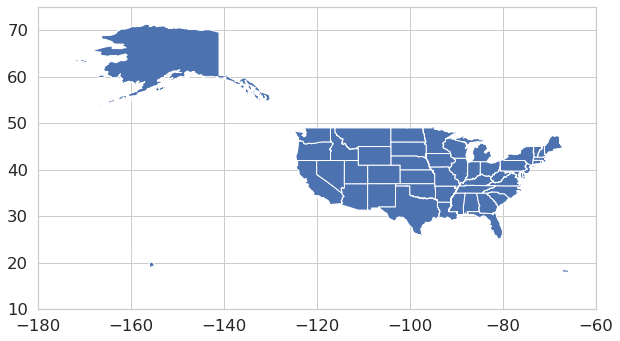

In [55]:
#A map visualization of US states
map_df = gpd.read_file('gz_2010_us_040_00_5m.json')
map_df.plot(figsize=(10, 10));
plt.xlim(-180,-60);
plt.ylim(10,75);

In [56]:
map_df.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.33,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.95,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.08,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.48,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.22,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In order to visiualize the **mortality rate of Covid-19 in US**, we merge the `map_df` dataframe with our `US_state` dataframe.

In [57]:
#We found that the map dataframe only have data for 50 states and 2 territories 
map_df.shape

(52, 6)

In [58]:
map_df['NAME']

0                  Alabama
1                   Alaska
2                  Arizona
3                 Arkansas
4               California
5                 Colorado
6              Connecticut
7                 Delaware
8     District of Columbia
9                  Florida
10                 Georgia
11                  Hawaii
12                   Idaho
13                Illinois
14                 Indiana
15                    Iowa
16                  Kansas
17                Kentucky
18               Louisiana
19                   Maine
20                Maryland
21           Massachusetts
22                Michigan
23               Minnesota
24             Mississippi
25                Missouri
26                 Montana
27                Nebraska
28                  Nevada
29           New Hampshire
30              New Jersey
31              New Mexico
32                New York
33          North Carolina
34            North Dakota
35                    Ohio
36                Oklahoma
3

Since the `map_df` dataframe have less states or territories in total (50 states, 2 territories), we are going to left join the two dataframe.

In [59]:
#merge the map_df dataframe with US_state dataframe
merged = map_df.set_index('NAME').merge(US_state, how='left', left_on="NAME", right_on="Province_State")

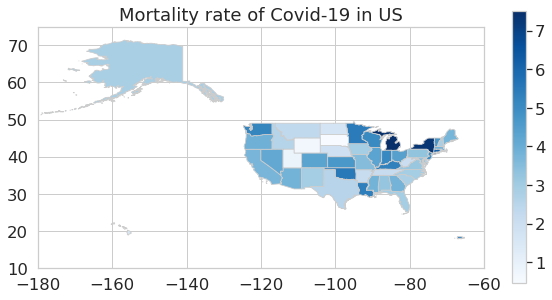

In [60]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Mortality_Rate'
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 5))
# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8',figsize=(10, 10))
plt.xlim(-180,-60);
plt.ylim(10,75);
plt.title('Mortality rate of Covid-19 in US');
fig.savefig("Mortality rate.png")

We can see from this visualization, US states have very different  mortality rate across the country. Since we want to classify each state with a certain level of mortality, we first found the min and max mortality rate and then split the mortality rate into `n` catagories. Then, we add a column labeled `catagory` to `US_state` that contains the level of mortality.

In [61]:
min_mortality, max_mortality = [np.min(merged['Mortality_Rate']), np.max(merged['Mortality_Rate'])]
min_mortality, max_mortality

(0.4539559014267186, 7.49569679451788)

We first use `3` catagories.

In [62]:
#n = 3
catagory = []
for i in np.arange(56):
    val = US_state.loc[i,:]['Mortality_Rate']
    step = max_mortality / 3
    if val <= step:
        catagory.append('1-Low')
    elif step < val <= step*2:
        catagory.append('2-Medium')
    else:
        catagory.append('3-High')
US_state['catagory'] = catagory
US_state.head()

,Province_State,Country_Region,Lat,Long,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,catagory
0,Alabama,US,32.32,-86.90,4712,153,-306.00,4559.00,100.49,42538.00,620.00,3.25,907.21,13.16,2-Medium
1,Alaska,US,61.37,-152.40,314,9,147.00,305.00,52.53,9655.00,39.00,2.87,1615.23,12.42,2-Medium
2,American Samoa,US,-14.27,-170.13,0,0,0.00,0.00,0.00,3.00,0.00,0.00,5.39,0.00,1-Low
3,Arizona,US,33.73,-111.43,4724,180,539.00,4544.00,64.90,51045.00,566.00,3.81,701.29,11.98,2-Medium
4,Arkansas,US,34.97,-92.37,1744,38,703.00,1706.00,67.36,24141.00,291.00,2.18,932.44,16.69,1-Low


Let's see how the map will look like using the catagory we just assigned to each state.

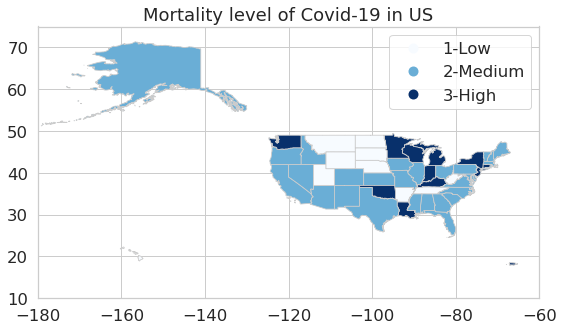

In [63]:
#merge the map_df dataframe with state dataframe
merged = map_df.set_index('NAME').merge(US_state, how='left', left_on="NAME", right_on="Province_State")
# set a variable that will call whatever column we want to visualise on the map
variable = 'catagory'
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 5))
# create map
merged.plot(column=variable, legend=True, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8',figsize=(10, 10))
plt.xlim(-180,-60);
plt.ylim(10,75);
plt.title('Mortality level of Covid-19 in US');
fig.savefig("Mortality level.png")

In [64]:
merged['catagory'].unique()

array(['2-Medium', '1-Low', '3-High'], dtype=object)

## Visualization of the dataset

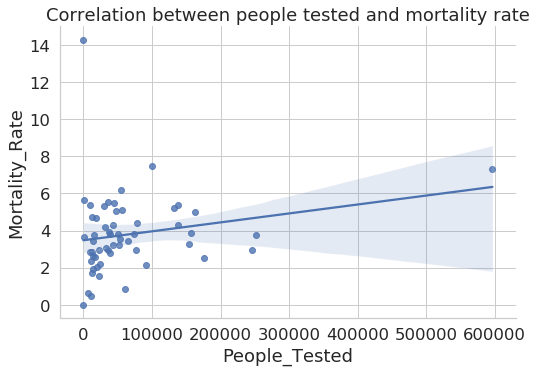

In [65]:
#Correlation between people tested and mortality rate
sns.lmplot(x = "People_Tested", y = "Mortality_Rate", height=5, aspect=1.5, data = US_state);
plt.title('Correlation between people tested and mortality rate');

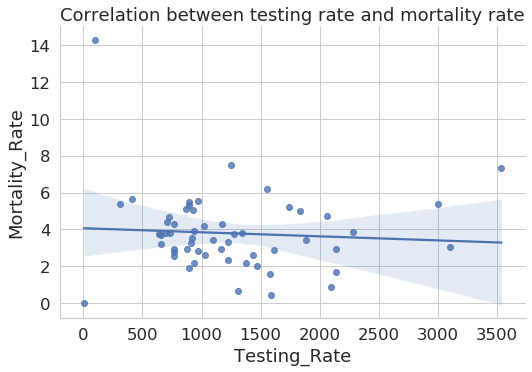

In [66]:
#Correlation between testing rate and mortality rate
sns.lmplot(x = "Testing_Rate", y = "Mortality_Rate", height=5, aspect=1.5, data = US_state);
plt.title('Correlation between testing rate and mortality rate');

## Part 3: Feature Engineering

In this part, we will select and create features for our  classification model. We decide to predict mortality level from the following inputs: ...

We want to include the number of confirmed cases of `neighbor states` as a feature.

In [67]:
#find the distance between two states
def distance(state1, state2):
    return np.sqrt(np.sum((state1 - state2)**2))

In [68]:
location = US_state[['Lat','Long']].to_numpy() #list of state longitude and latitude pairs
state_name = US_state[['Province_State']].to_numpy() #list of state names

In [69]:
#find n states that is nearest from the state s
def find_nearest_n(s, n):
    loc = US_state.loc[US_state['Province_State']==s][['Lat','Long']].to_numpy()
    dist = [] #list of distances from state s to other states
    dic = {} #dictionary of state name and its distance to state s. Key is distance, value is the corresponding state.
    counter = 0
    for i in location:
        a = distance(loc,i)
        dist.append(a)
        dic[a] = state_name[counter][0]
        counter+=1
    dist.sort()
    shortest_dist = dist[1:(n+1)]
    nearest_state = [dic.get(i) for i in shortest_dist]
    return nearest_state

We add columns labeled `Neighbors` (**5** neighbors of a state), `neighbors_cases` (number of confirmed cases in each neighbor), and `neighbors_avgcases` (average number of confirmed cases in **5** neighbor) to `US_state`.

In [70]:
#add columns with infomation about n neighbor states
def neighbor(n):
    neighbors_list = []
    stateslist = US_state['Province_State'].tolist()
    for i in stateslist:
        neighbors_list.append(find_nearest_n(i, n))
    US_state['Neighbors'] = neighbors_list

    neighbors_tested = []
    for i in neighbors_list:
        neighbors_tested.append([US_state[US_state['Province_State'] == j]['People_Tested'].values.item(0) for j in i])
    US_state['neighbors_tested'] = neighbors_tested 

    neighbors_avgtested = []
    for i in neighbors_tested:
        neighbors_avgtested.append(np.mean(i))
    US_state['neighbors_avgtested'] = neighbors_avgtested

In [71]:
#add columns with infomation about 5 neighbor states
neighbor(5)

In [72]:
US_state.head()

,Province_State,Country_Region,Lat,Long,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,catagory,Neighbors,neighbors_tested,neighbors_avgtested
0,Alabama,US,32.32,-86.90,4712,153,-306.00,4559.00,100.49,42538.00,620.00,3.25,907.21,13.16,2-Medium,"[Mississippi, Georgia, Tennessee, Louisiana, K...","[38765.0, 74208.0, 90586.0, 137999.0, 30596.0]",74430.80
1,Alaska,US,61.37,-152.40,314,9,147.00,305.00,52.53,9655.00,39.00,2.87,1615.23,12.42,2-Medium,"[Washington, Oregon, Hawaii, California, Idaho]","[131627.0, 37583.0, 22343.0, 251614.0, 16609.0]",91955.20
2,American Samoa,US,-14.27,-170.13,0,0,0.00,0.00,0.00,3.00,0.00,0.00,5.39,0.00,1-Low,"[Hawaii, California, Nevada, Arizona, Oregon]","[22343.0, 251614.0, 30751.0, 51045.0, 37583.0]",78667.20
3,Arizona,US,33.73,-111.43,4724,180,539.00,4544.00,64.90,51045.00,566.00,3.81,701.29,11.98,2-Medium,"[New Mexico, Utah, Nevada, Colorado, California]","[35613.0, 59944.0, 30751.0, 43307.0, 251614.0]",84245.80
4,Arkansas,US,34.97,-92.37,1744,38,703.00,1706.00,67.36,24141.00,291.00,2.18,932.44,16.69,1-Low,"[Missouri, Mississippi, Louisiana, Oklahoma, K...","[53759.0, 38765.0, 137999.0, 35536.0, 17676.0]",56747.00


Add feature from `selected_info` dataframe

In [73]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

print(Diff(US_state['Province_State'].tolist(),selected_info.index.tolist()))

['American Samoa', 'Virgin Islands']


Since the `selected_info` dataframe have fewer states or territories in total (50 states, 2 territories), we are going to left join it with `US_state`.

In [74]:
#merge the map_df dataframe with US_state dataframe
US = selected_info.merge(US_state, how='left', left_on=selected_info.index, right_on="Province_State")
US = US.set_index('Province_State')
US.columns

Index(['Population', 'Population65+', '#EligibleforMedicare',
       'MedicareEnrollment', 'Smokers_Percentage', '#HospitalEmployee',
       '#Hospitals', '#ICU_beds', 'Country_Region', 'Lat', 'Long', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'People_Tested',
       'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate',
       'Hospitalization_Rate', 'catagory', 'Neighbors', 'neighbors_tested',
       'neighbors_avgtested'],
      dtype='object')

## Part 4: Model Selection

In this part, we will select a classification model to predict the mortality level.

First, we use a `decision tree` model using 11 features.

In [118]:
#decision tree model
from sklearn import tree
dt_model= tree.DecisionTreeClassifier()
all_features = ['Population65+', '#EligibleforMedicare',
       'MedicareEnrollment', 'Smokers_Percentage',
                '#HospitalEmployee',"People_Tested", "Testing_Rate",
       '#Hospitals', '#ICU_beds', 'People_Tested',
       'neighbors_avgtested']

from sklearn.model_selection import train_test_split
train, test = train_test_split(US, test_size=0.1, random_state=42)
X_train = train[all_features]
Y_train = train["catagory"]
X_test = test[all_features]
Y_test = test["catagory"]
dt_model.fit(X_train, Y_train)
dt_model.predict(X_test)


training_accuracy = dt_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)
testing_accuracy = dt_model.score(X_test, Y_test)
print("Testing Accuracy: ", testing_accuracy)

Training Accuracy:  1.0
Testing Accuracy:  0.5


In [90]:
dp = dt_model.tree_.max_depth
dp

6

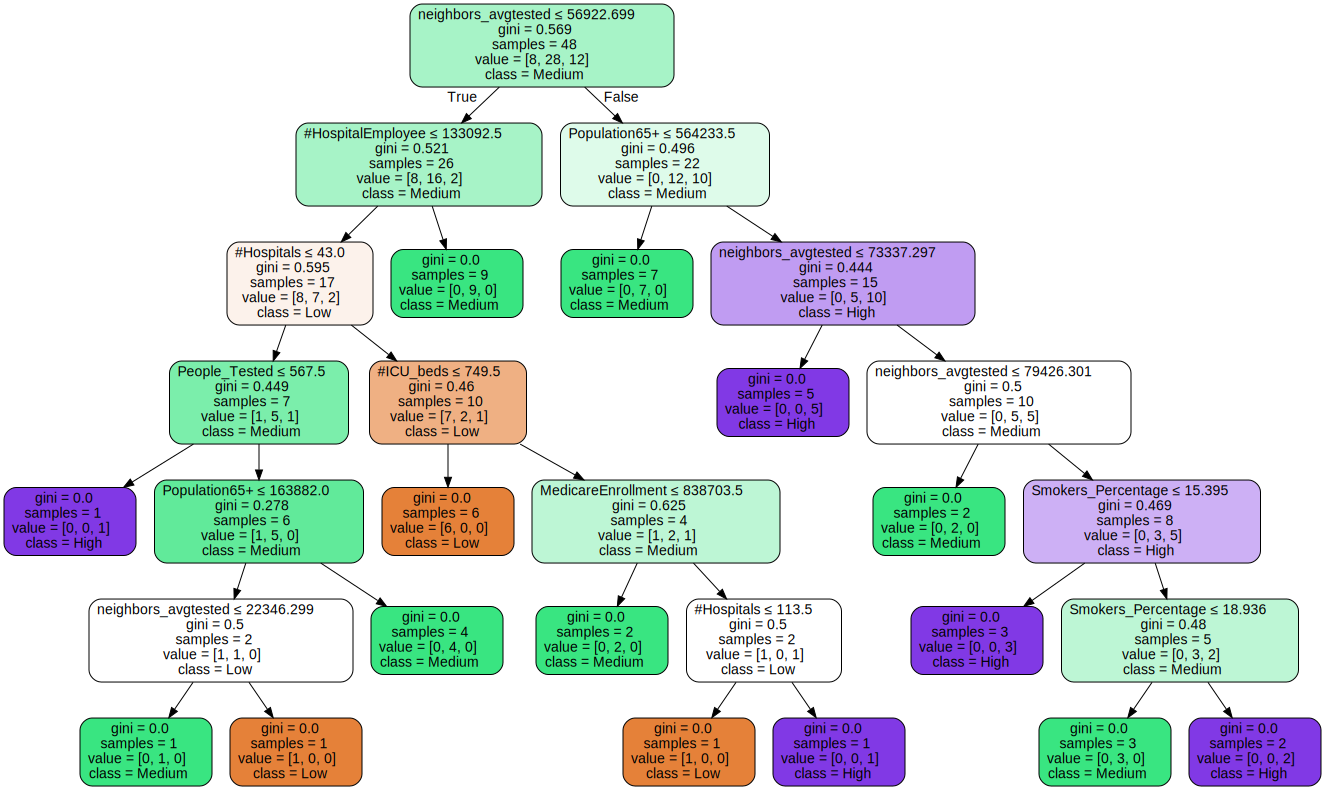

In [91]:
import graphviz
dot_data = tree.export_graphviz(dt_model, out_file=None, 
                      feature_names=all_features,  
                      class_names=["Low", "Medium", "High"],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)
graph

Use `Cross Validation` to find the best **tree depth** for optimal accuracy

In [95]:
from sklearn.model_selection import cross_val_score
tree_depth = range(1,dp+1)
cv_scores = []
cv_scores_mean = []
accuracy = []
for depth in tree_depth:
    dt = tree.DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(dt, X_train, Y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores)
    cv_scores_mean.append(scores.mean())
    accuracy.append(dt.fit(X_train, Y_train).score(X_train, Y_train))
cv_scores_mean = np.array(cv_scores_mean)
accuracy = np.array(accuracy)

In [96]:
dt.tree_.max_depth

6

In [97]:
cv_scores, cv_scores_mean

([array([0.4       , 0.6       , 0.6       , 0.55555556, 0.44444444]),
  array([0.2       , 0.6       , 0.5       , 0.22222222, 0.33333333]),
  array([0.2       , 0.7       , 0.6       , 0.77777778, 0.44444444]),
  array([0.3       , 0.6       , 0.5       , 0.44444444, 0.44444444]),
  array([0.4       , 0.7       , 0.5       , 0.33333333, 0.55555556]),
  array([0.4       , 0.6       , 0.5       , 0.33333333, 0.55555556])],
 array([0.52      , 0.37111111, 0.54444444, 0.45777778, 0.49777778,
        0.47777778]))

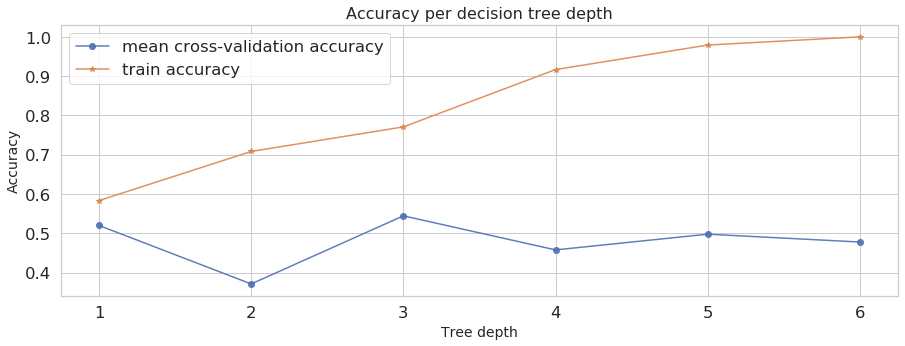

In [98]:
plt.figure(figsize=(15,5))
plt.plot(tree_depth, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
plt.plot(tree_depth, accuracy, '-*', label='train accuracy', alpha=0.9)
plt.title('Accuracy per decision tree depth', fontsize=16)
plt.xlabel('Tree depth', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(tree_depth)
plt.legend(labels=['mean cross-validation accuracy','train accuracy']);

In [99]:
index = cv_scores_mean.argmax()
best_tree_depth = tree_depth[index]
best_tree_cv_score = cv_scores_mean[index]
print(f'The depth-{best_tree_depth} tree achieves the best mean cross-validation accuracy of {best_tree_cv_score} on training dataset')


The depth-3 tree achieves the best mean cross-validation accuracy of 0.5444444444444445 on training dataset


Using the optimal tree depth that we find through **cross-validation**, we update our decision tree model with a parameter `max_depth=3`

In [120]:
#decision tree model
from sklearn import tree
dt_model= tree.DecisionTreeClassifier(max_depth=3)
all_features = ['Population65+', '#EligibleforMedicare',
       'MedicareEnrollment', 'Smokers_Percentage',
                '#HospitalEmployee',"People_Tested", "Testing_Rate",
       '#Hospitals', '#ICU_beds', 'People_Tested',
       'neighbors_avgtested']

from sklearn.model_selection import train_test_split
train, test = train_test_split(US, test_size=0.1, random_state=42)
X_train = train[all_features]
Y_train = train["catagory"]
X_test = test[all_features]
Y_test = test["catagory"]
dt_model.fit(X_train, Y_train)
dt_model.predict(X_test)


training_accuracy = dt_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)
testing_accuracy = dt_model.score(X_test, Y_test)
print("Testing Accuracy: ", testing_accuracy)

Training Accuracy:  0.7708333333333334
Testing Accuracy:  0.8333333333333334


**We managed to use tuning to achieve a higher accuracy of the model!!**